# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
!pip install dython

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from dython.nominal import associations


# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
path = './dataset_inisiasi.csv'
df = pd.read_csv(path)
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
features = [
    # 'num_voted_users',
    'gross',
    'budget',
    'duration',
    'imdb_score',
    'movie_facebook_likes',
    'num_critic_for_reviews'
]

df = df[features]
df.head(10)

,gross,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews
0,760505847.0,237000000.0,178.0,7.9,33000,723.0
1,309404152.0,300000000.0,169.0,7.1,0,302.0
2,200074175.0,245000000.0,148.0,6.8,85000,602.0
3,448130642.0,250000000.0,164.0,8.5,164000,813.0
4,NaN,NaN,NaN,7.1,0,NaN
5,73058679.0,263700000.0,132.0,6.6,24000,462.0
6,336530303.0,258000000.0,156.0,6.2,0,392.0
7,200807262.0,260000000.0,100.0,7.8,29000,324.0
8,458991599.0,250000000.0,141.0,7.5,118000,635.0
9,301956980.0,250000000.0,153.0,7.5,10000,375.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gross                   4159 non-null   float64
 1   budget                  4551 non-null   float64
 2   duration                5028 non-null   float64
 3   imdb_score              5043 non-null   float64
 4   movie_facebook_likes    5043 non-null   int64  
 5   num_critic_for_reviews  4993 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 236.5 KB


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [6]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe())

Shape of the dataset: (5043, 6)


,gross,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews
0,760505847.0,237000000.0,178.0,7.9,33000,723.0
1,309404152.0,300000000.0,169.0,7.1,0,302.0
2,200074175.0,245000000.0,148.0,6.8,85000,602.0
3,448130642.0,250000000.0,164.0,8.5,164000,813.0
4,NaN,NaN,NaN,7.1,0,NaN



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gross                   4159 non-null   float64
 1   budget                  4551 non-null   float64
 2   duration                5028 non-null   float64
 3   imdb_score              5043 non-null   float64
 4   movie_facebook_likes    5043 non-null   int64  
 5   num_critic_for_reviews  4993 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 236.5 KB
None

Statistical Summary:


,gross,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews
count,4.159000e+03,4.551000e+03,5028.000000,5043.000000,5043.000000,4993.000000
mean,4.846841e+07,3.975262e+07,107.201074,6.442138,7525.964505,140.194272
std,6.845299e+07,2.061149e+08,25.197441,1.125116,19320.445110,121.601675
min,1.620000e+02,2.180000e+02,7.000000,1.600000,0.000000,1.000000
25%,5.340988e+06,6.000000e+06,93.000000,5.800000,0.000000,50.000000
50%,2.551750e+07,2.000000e+07,103.000000,6.600000,166.000000,110.000000
75%,6.230944e+07,4.500000e+07,118.000000,7.200000,3000.000000,195.000000
max,7.605058e+08,1.221550e+10,511.000000,9.500000,349000.000000,813.000000


In [7]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 1441
Duplicated values: 122


In [8]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
gross                     4035
budget                     439
duration                   191
imdb_score                  78
movie_facebook_likes       876
num_critic_for_reviews     528
dtype: int64


In [9]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['gross', 'budget', 'duration', 'imdb_score', 'movie_facebook_likes', 'num_critic_for_reviews']
Categorical Columns: []


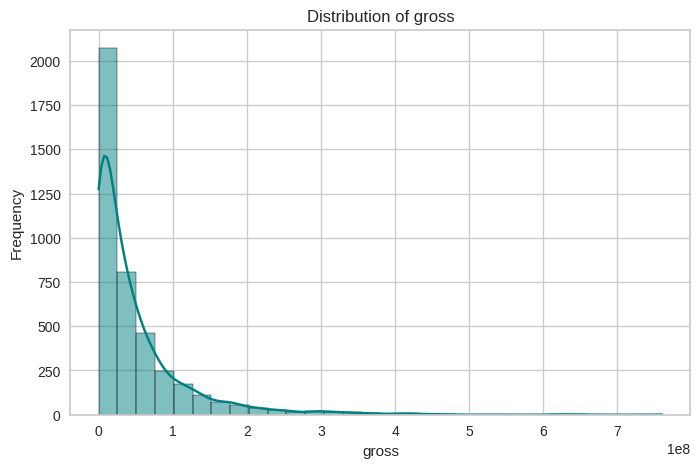

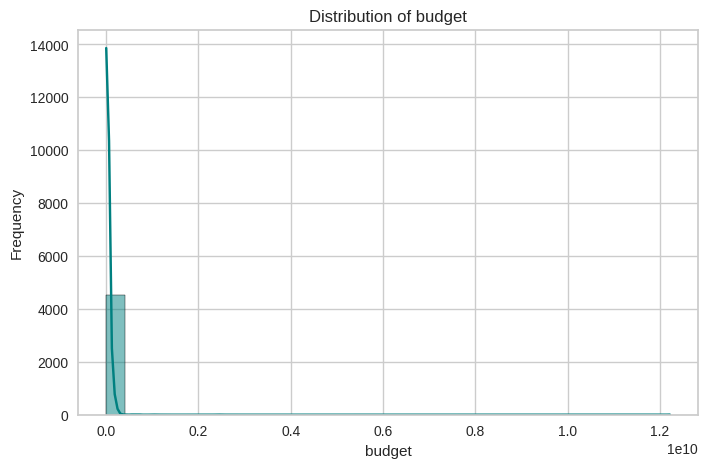

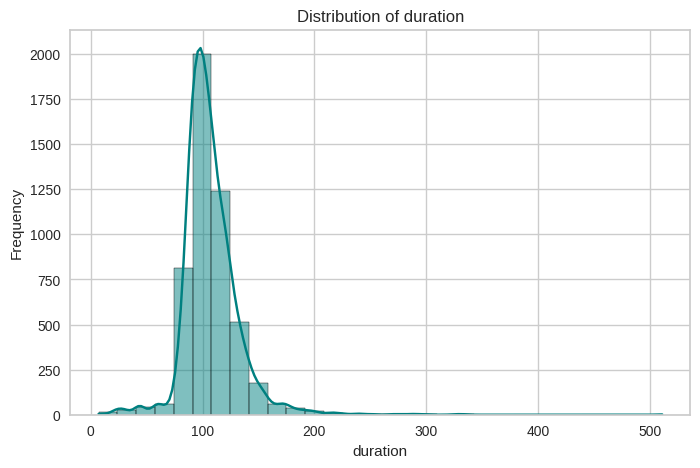

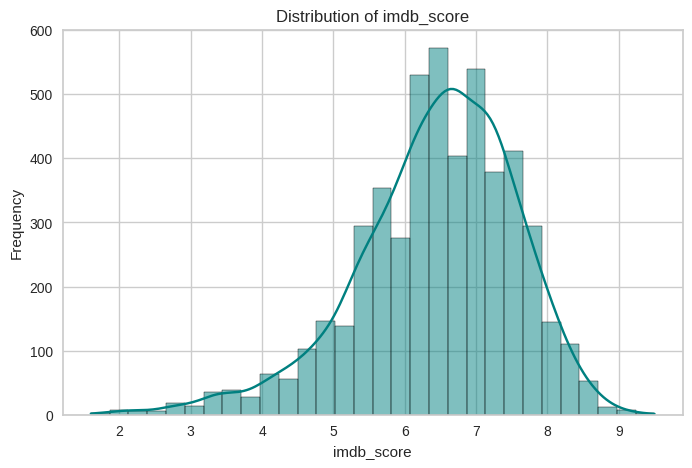

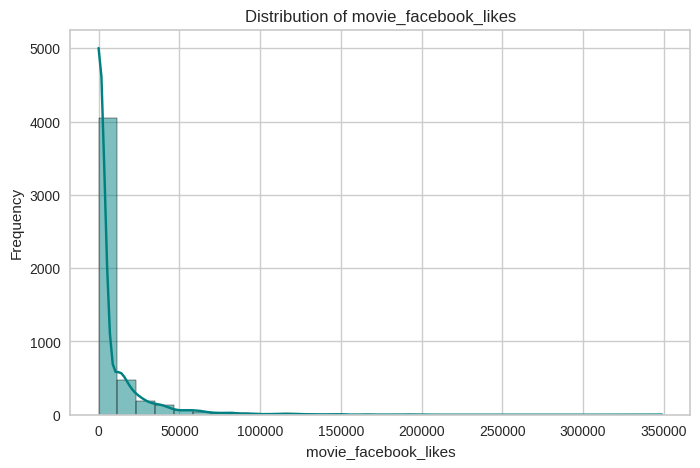

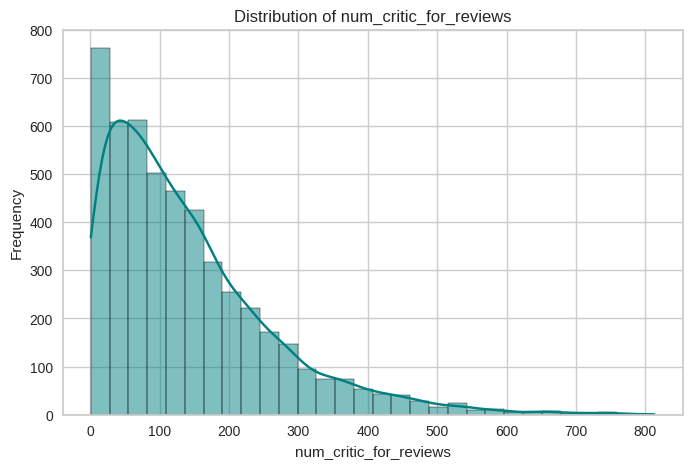

In [10]:
def plot_histograms(df, numerical_columns):
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        # Create a histogram with KDE
        sns.histplot(df[column], bins=30, kde=True, color='#008080')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()


plot_histograms(df, numerical_columns)

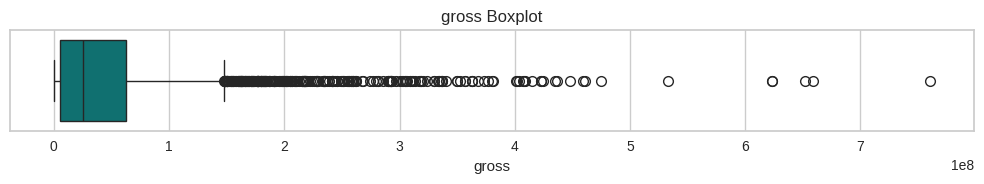


Summary Statistics for gross:
 count    4.159000e+03
mean     4.846841e+07
std      6.845299e+07
min      1.620000e+02
25%      5.340988e+06
50%      2.551750e+07
75%      6.230944e+07
max      7.605058e+08
Name: gross, dtype: float64


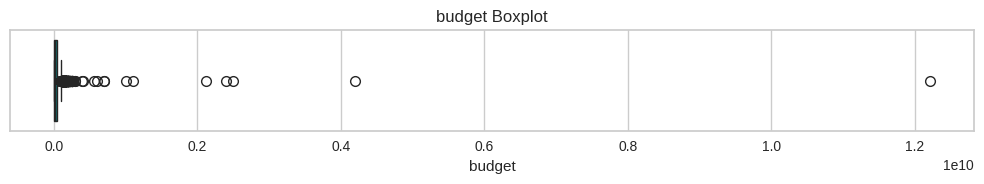


Summary Statistics for budget:
 count    4.551000e+03
mean     3.975262e+07
std      2.061149e+08
min      2.180000e+02
25%      6.000000e+06
50%      2.000000e+07
75%      4.500000e+07
max      1.221550e+10
Name: budget, dtype: float64


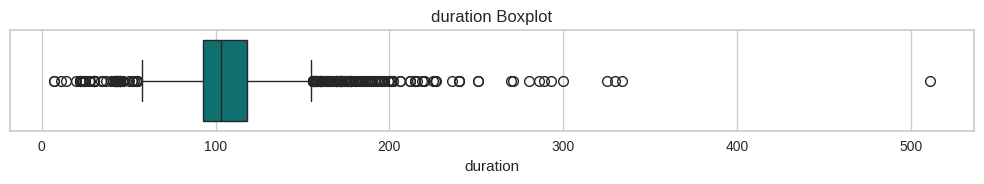


Summary Statistics for duration:
 count    5028.000000
mean      107.201074
std        25.197441
min         7.000000
25%        93.000000
50%       103.000000
75%       118.000000
max       511.000000
Name: duration, dtype: float64


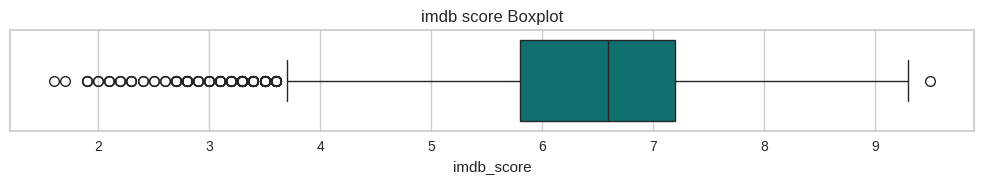


Summary Statistics for imdb score:
 count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64


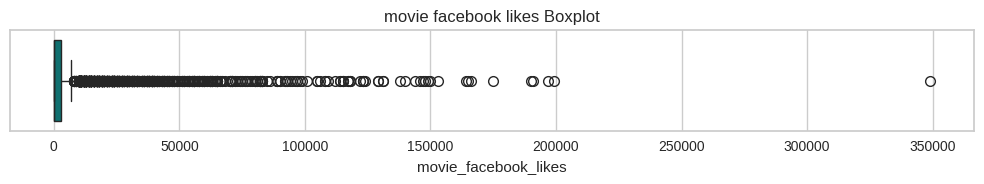


Summary Statistics for movie facebook likes:
 count      5043.000000
mean       7525.964505
std       19320.445110
min           0.000000
25%           0.000000
50%         166.000000
75%        3000.000000
max      349000.000000
Name: movie_facebook_likes, dtype: float64


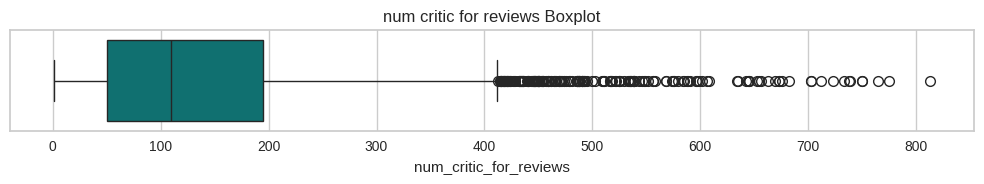


Summary Statistics for num critic for reviews:
 count    4993.000000
mean      140.194272
std       121.601675
min         1.000000
25%        50.000000
50%       110.000000
75%       195.000000
max       813.000000
Name: num_critic_for_reviews, dtype: float64


In [11]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))

    # Create a boxplot with the specified color
    sns.boxplot(x=data[column], color='teal')
    plt.title(f'{title} Boxplot')

    plt.tight_layout()
    plt.show()

    # Print summary statistics for the specified column
    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

for column in numerical_columns:
    univariate_analysis(df, column, column.replace('_', ' '))

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [12]:
# Handling Missing Values using Interpolation
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'\nMissing values after interpolation: {df.isna().sum().sum()}')



Missing values after interpolation: 0


In [13]:
# Drop duplicates
df.drop_duplicates(inplace=True)

print(f'\nDuplicated values after dropping: {df.duplicated().sum()}')



Duplicated values after dropping: 0


In [14]:
df_bin = df.copy()
# Define bin edges based on your desired ranges
bin_edges = [0, 10000000, 50000000, 100000000, 200000000, float('inf')]

# Create bin labels
bin_labels = ['0-10M', '10M-50M', '50M-100M', '100M-200M', '200M+']

# Perform binning
df_bin['gross_binned'] = pd.cut(df_bin['gross'], bins=bin_edges, labels=bin_labels, right=False)

# Print the updated DataFrame
df_bin = df_bin.drop(columns=['gross'])
df_bin.head()


,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews,gross_binned
0,237000000.0,178.0,7.9,33000,723.0,200M+
1,300000000.0,169.0,7.1,0,302.0,200M+
2,245000000.0,148.0,6.8,85000,602.0,200M+
3,250000000.0,164.0,8.5,164000,813.0,200M+
4,256850000.0,148.0,7.1,0,637.5,200M+


In [15]:
def detect_outliers_iteratively(df, max_iter=5, contamination=0.05, min_remaining_ratio=0.8):
    """
    Deteksi outlier secara bertahap menggunakan Isolation Forest.

    Params:
        df: DataFrame, data yang ingin diperiksa
        max_iter: int, maksimum jumlah iterasi
        contamination: float, proporsi outlier per iterasi
        min_remaining_ratio: float, batas minimal rasio data yang masih harus ada (untuk mencegah hilangnya terlalu banyak data)

    Returns:
        cleaned_df: Data tanpa outlier
        all_outliers_index: Index outlier yang terdeteksi selama semua iterasi
    """

    df_clean = df.copy()
    scaler = StandardScaler()
    all_outliers_index = set()

    for i in range(max_iter):
        print(f"\n🌀 Iterasi ke-{i+1} - Jumlah data: {len(df_clean)}")

        if len(df_clean) < min_remaining_ratio * len(df):
            print("⚠️ Rasio data tersisa terlalu kecil, proses dihentikan.")
            break

        X_scaled = scaler.fit_transform(df_clean)
        iso = IsolationForest(contamination=contamination, random_state=42)
        preds = iso.fit_predict(X_scaled)

        current_outliers = df_clean[preds == -1]
        current_outlier_indices = current_outliers.index

        print(f"🔎 Outlier ditemukan: {len(current_outliers)}")

        # Simpan index dan buang dari data
        all_outliers_index.update(current_outlier_indices)
        df_clean = df_clean.drop(index=current_outlier_indices)

        if len(current_outliers) == 0:
            print("✅ Tidak ada lagi outlier. Proses selesai.")
            break

    return df_clean, list(all_outliers_index)


In [16]:
df_scaled = df_bin.copy()

le = LabelEncoder()
le.classes_ = ['0-10M', '10M-50M', '50M-100M', '100M-200M', '200M+']  # urutan custom kalau mau
df_scaled['gross_binned'] = le.fit_transform(df_scaled['gross_binned']) # Fit_transform is used here to fit the label encoder to the data and then transform it.

scaler = StandardScaler()
#Only scale numerical features, gross_binned is categorical and already encoded
numerical_features = df_scaled.select_dtypes(include=['number']).columns
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
df_scaled.head()

,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews,gross_binned
0,0.983820,2.809721,1.294666,1.340629,4.876514,1.049037
1,1.295367,2.453253,0.585111,-0.381722,1.371744,1.049037
2,1.023381,1.621494,0.319027,4.054635,3.869205,1.049037
3,1.048107,2.255215,1.826833,8.177837,5.625752,1.049037
4,1.081982,1.621494,0.585111,-0.381722,4.164738,1.049037


In [17]:
cleaned_data, outlier_indices = detect_outliers_iteratively(df_scaled)
print("Data bersih:", cleaned_data.shape)
print("Total outlier terdeteksi:", len(outlier_indices))



🌀 Iterasi ke-1 - Jumlah data: 4942
🔎 Outlier ditemukan: 248

🌀 Iterasi ke-2 - Jumlah data: 4694
🔎 Outlier ditemukan: 235

🌀 Iterasi ke-3 - Jumlah data: 4459
🔎 Outlier ditemukan: 223

🌀 Iterasi ke-4 - Jumlah data: 4236
🔎 Outlier ditemukan: 212

🌀 Iterasi ke-5 - Jumlah data: 4024
🔎 Outlier ditemukan: 202
Data bersih: (3822, 6)
Total outlier terdeteksi: 1120


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [18]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
kmeans.fit(cleaned_data)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to your DataFrame
cleaned_data['cluster'] = cluster_labels

# Now you can analyze the clusters
cleaned_data.head()


,budget,duration,imdb_score,movie_facebook_likes,num_critic_for_reviews,gross_binned,cluster
59,0.504136,-0.636137,-0.213140,-0.381722,0.206263,-0.368805,1
100,-0.000273,-0.042024,0.230333,0.348972,0.414385,-0.368805,1
121,0.553588,-0.715353,0.230333,-0.381722,0.247887,-0.368805,1
143,0.553588,-0.754960,-0.922695,-0.381722,-0.043483,0.340116,0
157,0.306329,-0.675745,-0.301834,-0.277337,-0.018509,-0.368805,1


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

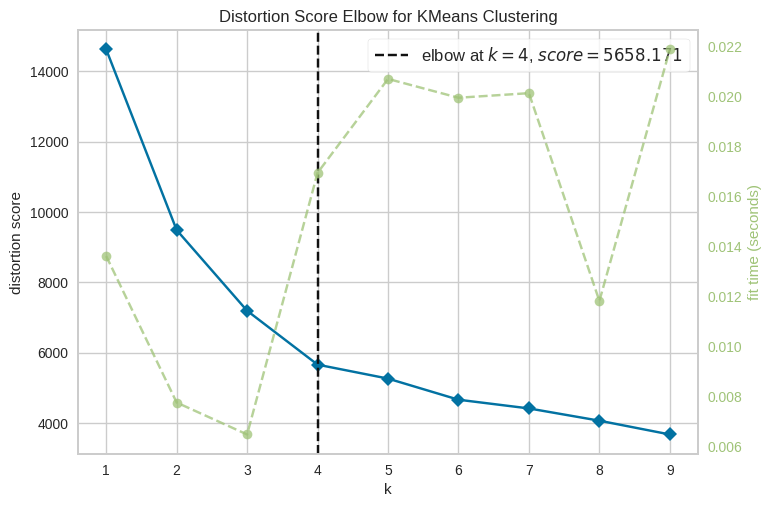

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(cleaned_data)

# Menampilkan grafik elbow untuk analisis
visualizer.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


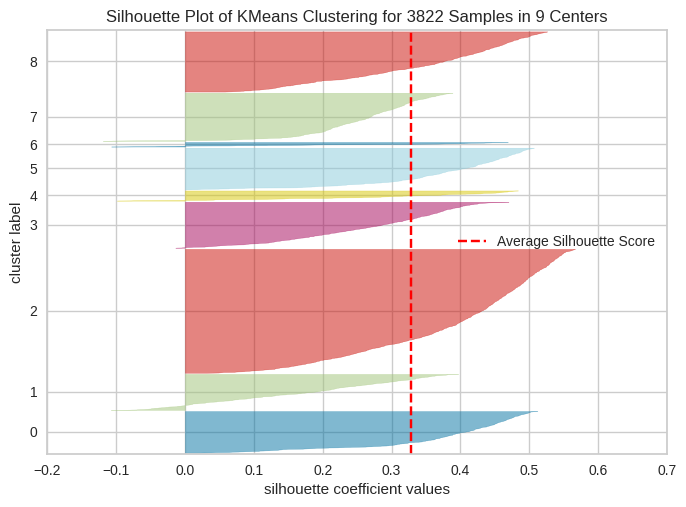

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3822 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:

fig, ax = plt.subplots(1, 1)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
visualizer.fit(cleaned_data)
visualizer.show()

In [21]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(cleaned_data, cluster_labels)
print(f"The average silhouette score is : {silhouette_avg}")

The average silhouette score is : 0.3761159579397438


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [22]:
# Buat fitur baru
df_bin['budget_per_minute'] = df_bin['budget'] / df_bin['duration']
df_bin['likes_per_review'] = df_bin['movie_facebook_likes'] / (df_bin['num_critic_for_reviews'] + 1)  # +1 untuk menghindari pembagi 0
df_bin['weighted_imdb_score'] = df_bin['imdb_score'] * df_bin['num_critic_for_reviews']
df_bin['budget_score_ratio'] = df_bin['budget'] / (df_bin['imdb_score'] + 1e-6)  # +epsilon kecil untuk hindari pembagi 0
df_bin['likes_score_ratio'] = df_bin['movie_facebook_likes'] / (df_bin['imdb_score'] + 1e-6)

df_bin = df_bin.drop(columns=['budget', 'duration', 'imdb_score', 'movie_facebook_likes', 'num_critic_for_reviews'])
df_bin.head()

,gross_binned,budget_per_minute,likes_per_review,weighted_imdb_score,budget_score_ratio,likes_score_ratio
0,200M+,1.331461e+06,45.580110,5711.70,3.000000e+07,4177.214661
1,200M+,1.775148e+06,0.000000,2144.20,4.225352e+07,0.000000
2,200M+,1.655405e+06,140.961857,4093.60,3.602941e+07,12499.998162
3,200M+,1.524390e+06,201.474201,6910.50,2.941176e+07,19294.115377
4,200M+,1.735473e+06,0.000000,4526.25,3.617605e+07,0.000000


In [23]:
df_scaled = df_bin.copy()

le = LabelEncoder()
le.classes_ = ['0-10M', '10M-50M', '50M-100M', '100M-200M', '200M+']  # urutan custom kalau mau
df_scaled['gross_binned'] = le.fit_transform(df_scaled['gross_binned']) # Fit_transform is used here to fit the label encoder to the data and then transform it.

scaler = StandardScaler()
#Only scale numerical features, gross_binned is categorical and already encoded
numerical_features = df_scaled.select_dtypes(include=['number']).columns
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])
df_scaled.head()

,gross_binned,budget_per_minute,likes_per_review,weighted_imdb_score,budget_score_ratio,likes_score_ratio
0,1.049037,0.540386,0.039354,5.389972,0.836541,1.169220
1,1.049037,0.784043,-0.187316,1.372841,1.262425,-0.390301
2,1.049037,0.718284,0.513689,3.567934,1.046100,4.276447
3,1.049037,0.646336,0.814618,6.739863,0.816096,6.812962
4,1.049037,0.762255,-0.187316,4.055114,1.051196,-0.390301


In [24]:
cleaned_data, outlier_indices = detect_outliers_iteratively(df_scaled)
print("Data bersih:", cleaned_data.shape)
print("Total outlier terdeteksi:", len(outlier_indices))



🌀 Iterasi ke-1 - Jumlah data: 4942
🔎 Outlier ditemukan: 248

🌀 Iterasi ke-2 - Jumlah data: 4694
🔎 Outlier ditemukan: 235

🌀 Iterasi ke-3 - Jumlah data: 4459
🔎 Outlier ditemukan: 223

🌀 Iterasi ke-4 - Jumlah data: 4236
🔎 Outlier ditemukan: 212

🌀 Iterasi ke-5 - Jumlah data: 4024
🔎 Outlier ditemukan: 202
Data bersih: (3822, 6)
Total outlier terdeteksi: 1120


In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
kmeans.fit(cleaned_data)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to your DataFrame
cleaned_data['cluster'] = cluster_labels

# Now you can analyze the clusters
cleaned_data.head()


,gross_binned,budget_per_minute,likes_per_review,weighted_imdb_score,budget_score_ratio,likes_score_ratio,cluster
177,1.757958,-0.177076,-0.187316,-0.864254,-0.199191,-0.390301,2
209,-0.368805,0.369234,-0.187316,0.104249,0.353214,-0.390301,3
214,-0.368805,0.125086,-0.187316,0.613668,0.095077,-0.390301,3
215,0.340116,0.266832,-0.187316,-0.409898,0.241474,-0.390301,0
230,1.757958,0.239510,-0.187316,0.520094,0.338543,-0.390301,2


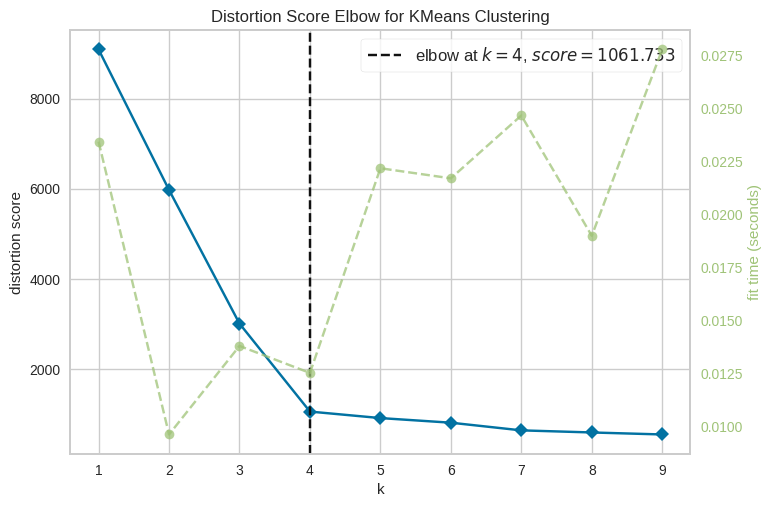

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(cleaned_data)

# Menampilkan grafik elbow untuk analisis
visualizer.show()

In [27]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(cleaned_data, cluster_labels)
print(f"The average silhouette score is : {silhouette_avg}")

The average silhouette score is : 0.684154137276072


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

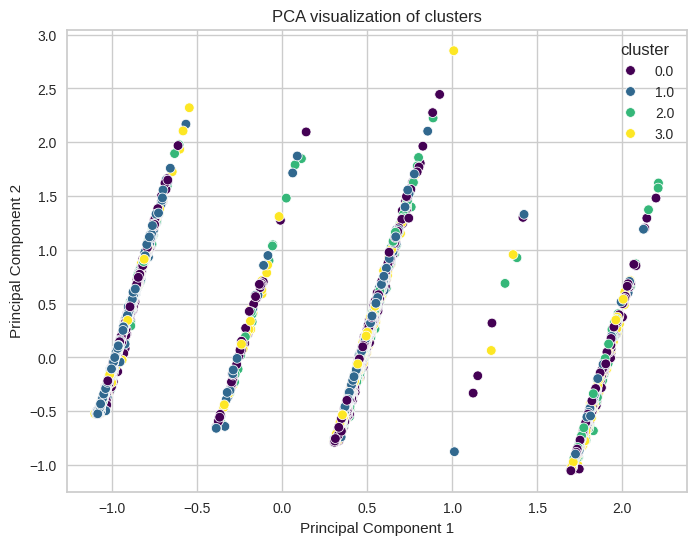

Explained Variance Ratio:
[0.72206582 0.23368557]


In [28]:

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
pca_result = pca.fit_transform(cleaned_data.drop(columns=['cluster']))

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = cleaned_data['cluster']

# Visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('PCA visualization of clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Explained variance ratio
print(f"Explained Variance Ratio:\n{pca.explained_variance_ratio_}")


### Interpretasi Target

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

In [29]:
df_invers = cleaned_data.copy()
df_invers = df_invers.drop(columns=['cluster'])
# Inverse transform the numerical features
numerical_features = df_invers.select_dtypes(include=['number']).columns
df_invers[numerical_features] = scaler.inverse_transform(df_invers[numerical_features])

# Inverse transform the 'gross_binned' column (categorical)
# Before inverse transform, round 'gross_binned' to the nearest integer to address numerical discrepancies
# introduced during preprocessing that are causing the error.
df_invers['gross_binned'] = df_invers['gross_binned'].round().astype(int)

# Now perform the inverse transform
le.classes_ = np.array(['0-10M', '10M-50M', '50M-100M', '100M-200M', '200M+'])
df_invers['gross_binned'] = le.inverse_transform(df_invers['gross_binned'])

df_invers.head()

,gross_binned,budget_per_minute,likes_per_review,weighted_imdb_score,budget_score_ratio,likes_score_ratio
177,200M+,2.500000e+04,0.0,157.5,2.000000e+05,0.0
209,10M-50M,1.019802e+06,0.0,1017.6,1.609375e+07,0.0
214,10M-50M,5.752212e+05,0.0,1470.0,8.666666e+06,0.0
215,50M-100M,8.333333e+05,0.0,561.0,1.287879e+07,0.0
230,200M+,7.835821e+05,0.0,1386.9,1.567164e+07,0.0


In [30]:
df_invers['cluster'] = cleaned_data['cluster']
df_invers.head()

,gross_binned,budget_per_minute,likes_per_review,weighted_imdb_score,budget_score_ratio,likes_score_ratio,cluster
177,200M+,2.500000e+04,0.0,157.5,2.000000e+05,0.0,2
209,10M-50M,1.019802e+06,0.0,1017.6,1.609375e+07,0.0,3
214,10M-50M,5.752212e+05,0.0,1470.0,8.666666e+06,0.0,3
215,50M-100M,8.333333e+05,0.0,561.0,1.287879e+07,0.0,0
230,200M+,7.835821e+05,0.0,1386.9,1.567164e+07,0.0,2


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [33]:
# Mendapatkan jumlah cluster
k = 4
features = df_invers.columns.tolist()
features.remove('cluster')
# Fungsi untuk analisis karakteristik cluster
def analyze_clusters(k):
    print("Analisis Karakteristik Setiap Cluster:")
    for cluster_id in range(k):
        print(f"\nCluster {cluster_id}:")
        # Mengambil data untuk cluster saat ini
        cluster_data = df_invers.loc[df_invers['cluster'] == cluster_id]

        # Menghitung rata-rata untuk setiap fitur dalam cluster
        for feature in features :
          # Check if the feature is numerical before calculating the mean
          if pd.api.types.is_numeric_dtype(cluster_data[feature]):
            feature_mean = cluster_data[feature].mean()
            print(f"Rata-rata {feature}: {feature_mean:.2f}")
          else:
            # For non-numerical features, you can print the mode or other relevant statistics
            feature_mode = cluster_data[feature].mode()[0]  # Get the mode
            print(f"Modus {feature}: {feature_mode}")

# Analisis karakteristik setiap cluster
analyze_clusters(k)

Analisis Karakteristik Setiap Cluster:

Cluster 0:
Modus gross_binned: 50M-100M
Rata-rata budget_per_minute: 251115.92
Rata-rata likes_per_review: 9.14
Rata-rata weighted_imdb_score: 500.32
Rata-rata budget_score_ratio: 4473466.62
Rata-rata likes_score_ratio: 91.31

Cluster 1:
Modus gross_binned: 0-10M
Rata-rata budget_per_minute: 91455.30
Rata-rata likes_per_review: 12.25
Rata-rata weighted_imdb_score: 380.85
Rata-rata budget_score_ratio: 1573606.14
Rata-rata likes_score_ratio: 73.17

Cluster 2:
Modus gross_binned: 200M+
Rata-rata budget_per_minute: 342583.43
Rata-rata likes_per_review: 4.79
Rata-rata weighted_imdb_score: 765.52
Rata-rata budget_score_ratio: 5844709.01
Rata-rata likes_score_ratio: 62.36

Cluster 3:
Modus gross_binned: 50M-100M
Rata-rata budget_per_minute: 248271.14
Rata-rata likes_per_review: 17.13
Rata-rata weighted_imdb_score: 1486.28
Rata-rata budget_score_ratio: 4111393.25
Rata-rata likes_score_ratio: 514.23


## Hasil interprestasi

# Analisis Karakteristik Cluster

## Cluster 0
- **Modus gross_binned:** 50M-100M
- **Rata-rata budget_per_minute:** 251,115.92
- **Rata-rata likes_per_review:** 9.14
- **Rata-rata weighted_imdb_score:** 500.32
- **Rata-rata budget_score_ratio:** 4,473,466.62
- **Rata-rata likes_score_ratio:** 91.31

**Interpretasi:**  
Cluster 0 berisi film-film dengan **pendapatan menengah-tinggi** dan **budget produksi per menit yang besar**.  
Film-film ini **cukup populer**, namun **kualitas berdasarkan IMDb score relatif biasa saja** jika dibandingkan dengan besarnya budget produksi.  
Cluster ini merepresentasikan **blockbuster biasa** — produksi besar tapi tidak selalu unggul dalam kualitas.

---

## Cluster 1
- **Modus gross_binned:** 0-10M
- **Rata-rata budget_per_minute:** 91,455.30
- **Rata-rata likes_per_review:** 12.25
- **Rata-rata weighted_imdb_score:** 380.85
- **Rata-rata budget_score_ratio:** 1,573,606.14
- **Rata-rata likes_score_ratio:** 73.17

**Interpretasi:**  
Cluster 1 berisi **film-film dengan pendapatan kecil** dan **budget rendah**.  
Walaupun demikian, film-film ini **cukup disukai** oleh audiens dibandingkan dengan banyaknya kritik.  
Cluster ini merepresentasikan **film indie atau film kecil** yang mendapatkan **respons positif** dari penonton.

---

## Cluster 2
- **Modus gross_binned:** 200M+
- **Rata-rata budget_per_minute:** 342,583.43
- **Rata-rata likes_per_review:** 4.79
- **Rata-rata weighted_imdb_score:** 765.52
- **Rata-rata budget_score_ratio:** 5,844,709.01
- **Rata-rata likes_score_ratio:** 62.36

**Interpretasi:**  
Cluster 2 berisi **film-film mega-blockbuster** dengan **pendapatan kotor sangat tinggi** dan **budget produksi sangat besar**.  
Film-film dalam cluster ini **memiliki kualitas tinggi** berdasarkan IMDb score, tetapi **popularitas di sosial media tidak terlalu tinggi** relatif terhadap kualitasnya.  
Cluster ini cocok untuk menggambarkan **film-film besar studio** atau **franchise besar**.

---

## Cluster 3
- **Modus gross_binned:** 50M-100M
- **Rata-rata budget_per_minute:** 248,271.14
- **Rata-rata likes_per_review:** 17.13
- **Rata-rata weighted_imdb_score:** 1486.28
- **Rata-rata budget_score_ratio:** 4,111,393.25
- **Rata-rata likes_score_ratio:** 514.23

**Interpretasi:**  
Cluster 3 berisi film-film dengan **pendapatan menengah-tinggi** yang **sangat populer** di sosial media dan **memiliki kualitas sangat tinggi** berdasarkan skor IMDb.  
Film-film ini adalah **kombinasi sempurna** antara **popularitas dan kualitas**, mewakili **film-film yang sukses besar** baik secara kritik maupun penerimaan publik — seperti **pemenang penghargaan** atau **film fenomenal**.


# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [34]:
df_invers.to_csv('dataset_clustering.csv', index=False)